In [139]:
import configparser
from pathlib import Path

config = configparser.ConfigParser()
config.read('../../../data/config/config.cfg')

phenopackets_out_dir = ('..' / Path(config.get('Paths', 'phenopackets_out'))).resolve()

phenopackets_out_dir

WindowsPath('C:/Users/Surface/OneDrive/Documents/DataSpell/ERKER2Phenopackets/ERKER2Phenopackets/data/out/phenopackets')

# read in data from phenopackets

In [140]:
from ERKER2Phenopackets.src.utils.io import read_files

example_phenopackets_dir = phenopackets_out_dir / 'example-phenopackets-from-synthetic-data'
is_synth_data = True
pps = read_files(example_phenopackets_dir)

# convert phenopackets to dataframe
Necessary fields:
- id
- zygosity
- cHGVS mutation
- Obsesity Class and timestamp

In [141]:
from typing import Tuple, Any
from phenopackets import Phenopacket

sex_map = {0: 'unknown', 1: 'female', 2: 'male', 3: 'other'}

def extract_phenotype(phenotypic_features, i) -> Tuple[str, str, bool, int]:
    phenotypic_features = phenotypic_features[i]
    obesity_class_hpo = phenotypic_features.type.id
    obesity_class = phenotypic_features.type.label
    excluded = phenotypic_features.excluded
    onset = phenotypic_features.onset.timestamp.ToSeconds()
    return obesity_class_hpo, obesity_class, excluded, onset

def extract_fields(phenopacket: Phenopacket):
    pp_id = int(phenopacket.id)
    dob = phenopacket.subject.date_of_birth.ToSeconds()
    sex = sex_map[phenopacket.subject.sex]

    try:
        variation_descriptor = phenopacket.interpretations[0].diagnosis.genomic_interpretations[0].variant_interpretation.variation_descriptor
        c_hgvs = variation_descriptor.expressions[1].value
        zygosity = variation_descriptor.allelic_state.label
    except IndexError:
        return None

    phenotypic_features = phenopacket.phenotypic_features

    phenotype_data = []
    for i in range(5):
        try:
            obesity_class_hpo, obesity_class, excluded, onset = extract_phenotype(phenotypic_features, i)
        except IndexError:
            obesity_class_hpo, obesity_class, excluded, onset = None, None, None, None
        phenotype_data.extend([obesity_class_hpo, obesity_class, excluded, onset])

    return tuple([pp_id, dob, sex, zygosity, c_hgvs] + phenotype_data)


In [142]:
# todo: some people have multiple variants max 3

In [143]:
phenopacket = pps[0]
variation_descriptor = phenopacket.interpretations[0].diagnosis.genomic_interpretations[0].variant_interpretation

phenopacket

id: "0"
subject {
  id: "0"
  date_of_birth {
    seconds: 946684800
  }
  sex: FEMALE
  taxonomy {
    id: "NCBITaxon:9606"
    label: "Homo sapiens"
  }
}
phenotypic_features {
  type {
    id: "HP:0001513"
    label: "Obesity"
  }
  excluded: true
  onset {
    timestamp {
      seconds: 708652800
    }
  }
}
interpretations {
  id: "e0dd47b3-6e13-4507-84a7-5606bee17024"
  progress_status: SOLVED
  diagnosis {
    disease {
      id: "ORPHA:71529"
      label: "Obesity due to melanocortin 4 receptor deficiency"
    }
    genomic_interpretations {
      subject_or_biosample_id: "0"
      interpretation_status: CONTRIBUTORY
      variant_interpretation {
        variation_descriptor {
          id: "id:A"
          expressions {
            syntax: "hgvs"
            value: "NP_005903.2:p.(Val103Ile)"
          }
          expressions {
            syntax: "hgvs"
            value: "NM_005912.3:c.181G>T"
          }
          allelic_state {
            id: "GENO:0000135"
            

In [144]:
for pp in pps:
    print(extract_fields(pp))

(0, 946684800, 'female', 'heterozygous', 'NM_005912.3:c.181G>T', 'HP:0001513', 'Obesity', True, 708652800, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
(1, 915148800, 'female', 'heterozygous', 'NM_005912.3:c.307G>A', 'HP:0001513', 'Obesity', True, 1254268800, 'HP:0001513', 'Obesity', False, 967507200, None, None, None, None, None, None, None, None, None, None, None, None)
None
None
(12, 757382400, 'male', 'heterozygous', 'NM_005912.3:c.307G>A', 'HP:0001513', 'Obesity', False, 1118793600, 'HP:0025500', 'Class II obesity', False, 1267056000, None, None, None, None, None, None, None, None, None, None, None, None)
(13, 757382400, 'male', 'heterozygous', 'NM_005912.3:c.307G>A', 'HP:0001513', 'Obesity', True, 1234051200, 'HP:0001507', 'Growth abnormality', True, 985219200, 'HP:0001507', 'Growth abnormality', False, 876528000, None, None, None, None, None, None, None, None)
None
None
None
(17, 1072915200, 'female', 'homozygous', 'NM_005912.3:

In [145]:
import polars as pl

data = list(filter(lambda x: x is not None, map(extract_fields, pps)))

data, len(data)

([(0,
   946684800,
   'female',
   'heterozygous',
   'NM_005912.3:c.181G>T',
   'HP:0001513',
   'Obesity',
   True,
   708652800,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None),
  (1,
   915148800,
   'female',
   'heterozygous',
   'NM_005912.3:c.307G>A',
   'HP:0001513',
   'Obesity',
   True,
   1254268800,
   'HP:0001513',
   'Obesity',
   False,
   967507200,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None),
  (12,
   757382400,
   'male',
   'heterozygous',
   'NM_005912.3:c.307G>A',
   'HP:0001513',
   'Obesity',
   False,
   1118793600,
   'HP:0025500',
   'Class II obesity',
   False,
   1267056000,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None),
  (13,
   757382400,
   'male',
   'heterozygous',
   'NM_005912.3:c.307G>A',
   'HP:0001513',
   'Obesity',
   True

In [146]:
columns = ['id', 'date_of_birth', 'sex', 'zygosity', 'c_hgvs', 'obesity_class_hpo0', 'obesity_class0', 'phenotype_refuted0', 'onset0', 'obesity_class_hpo1', 'obesity_class1', 'phenotype_refuted1', 'onset1', 'obesity_class_hpo2', 'obesity_class2', 'phenotype_refuted2', 'onset2', 'obesity_class_hpo3', 'obesity_class3', 'phenotype_refuted3', 'onset3', 'obesity_class_hpo4', 'obesity_class4', 'phenotype_refuted4', 'onset4']
transposed_data = list(zip(*data))

df = pl.DataFrame({col: transposed_data[i] for i, col in enumerate(columns)})

In [147]:
df.head(50)

id,date_of_birth,sex,zygosity,c_hgvs,obesity_class_hpo0,obesity_class0,phenotype_refuted0,onset0,obesity_class_hpo1,obesity_class1,phenotype_refuted1,onset1,obesity_class_hpo2,obesity_class2,phenotype_refuted2,onset2,obesity_class_hpo3,obesity_class3,phenotype_refuted3,onset3,obesity_class_hpo4,obesity_class4,phenotype_refuted4,onset4
i64,i64,str,str,str,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64
0,946684800,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,708652800,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1,915148800,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1254268800,"""HP:0001513""","""Obesity""",false,967507200,null,null,null,null,null,null,null,null,null,null,null,null
12,757382400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",false,1118793600,"""HP:0025500""","""Class II obesi…",false,1267056000,null,null,null,null,null,null,null,null,null,null,null,null
13,757382400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1234051200,"""HP:0001507""","""Growth abnorma…",true,985219200,"""HP:0001507""","""Growth abnorma…",false,876528000,null,null,null,null,null,null,null,null
17,1072915200,"""female""","""homozygous""","""NM_005912.3:c.…","""HP:0025500""","""Class II obesi…",true,638409600,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
18,1136073600,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,916272000,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,1009843200,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1087257600,"""HP:0001513""","""Obesity""",true,825811200,"""HP:0001507""","""Growth abnorma…",false,976406400,null,null,null,null,null,null,null,null
20,1072915200,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,872208000,"""HP:0025499""","""Class I obesit…",false,674524800,"""HP:0001507""","""Growth abnorma…",false,1037750400,null,null,null,null,null,null,null,null
21,1136073600,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,938563200,"""HP:0001513""","""Obesity""",true,1149724800,"""HP:0001507""","""Growth abnorma…",false,1451606400,null,null,null,null,null,null,null,null


# Data Cleaning

There is only one person with an unspecified zygosity, so we can drop this person.

In [148]:
df = df.filter(df['zygosity'] != 'unspecified zygosity')

In [149]:
# add new timestamps to make the data more realistic
if is_synth_data:
    from ERKER2Phenopackets.src.utils.dateutils import date_to_seconds, seconds_to_date, generate_random_date
    def random_onsets():
        seconds_per_day = 60 * 60 * 24
        dob = generate_random_date('1990-01-01', '2010-01-01')
        dob_seconds = date_to_seconds(dob)
        # dates:
        # 1. untersuchung bei geburt
        # 2. u6: 10 - 12 monate
        # 3. u7: 21 - 24 monate
        # 4. u8: 46 - 48 monate
        # 5. u9: 60 - 64 monate
        intervals = [
            (0, 35),
            (304, 365),
            (639, 730),
            (1399, 1460),
            (1825, 1947)
        ]
    
        onset_dates = [dob_seconds]
        for interval in intervals:
            min_days, max_days = interval
            min_date = seconds_to_date(dob_seconds + min_days * seconds_per_day)
            max_date = seconds_to_date(dob_seconds + max_days * seconds_per_day)
            onset_dates.append(date_to_seconds(generate_random_date(min_date, max_date)))
    
        return onset_dates
    
    dob, u1, u6, u7, u8, u9 = [], [], [], [], [], []
    
    for i in range(df.height):
        cur_dob, cur_u1, cur_u6, cur_u7, cur_u8, cur_u9 = random_onsets()
        dob.append(cur_dob)
        u1.append(cur_u1)
        u6.append(cur_u6)
        u7.append(cur_u7)
        u8.append(cur_u8)
        u9.append(cur_u9)
    
    df = df.with_columns(
        pl.Series(name='date_of_birth', values=dob),
        pl.Series(name='onset0', values=u1),
        pl.Series(name='onset1', values=u6),
        pl.Series(name='onset2', values=u7),
        pl.Series(name='onset3', values=u8),
        pl.Series(name='onset4', values=u9),
    )

In [150]:
df.head(50)

id,date_of_birth,sex,zygosity,c_hgvs,obesity_class_hpo0,obesity_class0,phenotype_refuted0,onset0,obesity_class_hpo1,obesity_class1,phenotype_refuted1,onset1,obesity_class_hpo2,obesity_class2,phenotype_refuted2,onset2,obesity_class_hpo3,obesity_class3,phenotype_refuted3,onset3,obesity_class_hpo4,obesity_class4,phenotype_refuted4,onset4
i64,i64,str,str,str,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64
0,818553600,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,819158400,null,null,null,849571200,null,null,null,873849600,null,null,null,940464000,null,null,null,985219200
1,843696000,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,845424000,"""HP:0001513""","""Obesity""",false,870566400,null,null,null,898905600,null,null,null,966124800,null,null,null,1009411200
12,726883200,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",false,729907200,"""HP:0025500""","""Class II obesi…",false,755827200,null,null,null,784512000,null,null,null,850694400,null,null,null,885254400
13,1010966400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1013299200,"""HP:0001507""","""Growth abnorma…",true,1037923200,"""HP:0001507""","""Growth abnorma…",false,1069632000,null,null,null,1136937600,null,null,null,1169078400
17,967420800,"""female""","""homozygous""","""NM_005912.3:c.…","""HP:0025500""","""Class II obesi…",true,970272000,null,null,null,995328000,null,null,null,1026604800,null,null,null,1088640000,null,null,null,1132358400
18,1123545600,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1126051200,null,null,null,1151539200,null,null,null,1183680000,null,null,null,1247270400,null,null,null,1285113600
2,856310400,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,858816000,"""HP:0001513""","""Obesity""",true,885945600,"""HP:0001507""","""Growth abnorma…",false,917913600,null,null,null,977356800,null,null,null,1014336000
20,913939200,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,914544000,"""HP:0025499""","""Class I obesit…",false,944611200,"""HP:0001507""","""Growth abnorma…",false,970444800,null,null,null,1036800000,null,null,null,1081987200
21,1219276800,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1221350400,"""HP:0001513""","""Obesity""",true,1247702400,"""HP:0001507""","""Growth abnorma…",false,1275091200,null,null,null,1342569600,null,null,null,1381536000


# Preprocessing

Order dataframe by descending number of same c_hgvs mutations

In [151]:
from ERKER2Phenopackets.src.utils.polars_utils import sort_by_method

def c_hgvs_occurences(df: pl.DataFrame) -> pl.DataFrame:
    return  df.join(other=df.groupby('c_hgvs').agg(pl.count('c_hgvs').alias('count')).select(['c_hgvs','count']), on='c_hgvs', how='inner').select(['count'])

df = sort_by_method(df, c_hgvs_occurences)

In [152]:
# correct value of refuted columns to match phenotype: only Obesity has refuted true these are our negatives
if is_synth_data:
    df = df.with_columns(
        phenotype_refuted0=df['obesity_class0'] == 'Obesity',
        phenotype_refuted1=df['obesity_class1'] == 'Obesity',
        phenotype_refuted2=df['obesity_class2'] == 'Obesity',
        phenotype_refuted3=df['obesity_class3'] == 'Obesity',
        phenotype_refuted4=df['obesity_class4'] == 'Obesity',
    )

In [153]:
from ERKER2Phenopackets.src.utils.polars_utils import replace_value

# growth abnormality: not recorded phenotype -> replace null
growth_abnormality = 'Growth abnormality'
growth_abnormality_hpo = 'HP:0001507'

for i in range(5):
    df = replace_value(df, f'obesity_class{i}', growth_abnormality, None)
    df = replace_value(df, f'obesity_class_hpo{i}', growth_abnormality_hpo, None)

In [154]:
from ERKER2Phenopackets.src.analysis.ml.analysis_helper_methods import create_label
from ERKER2Phenopackets.src.utils.polars_utils import map_col

# 0: Obesity refuted
# 1: Overweight
# 2: Class I Obesity (HPO)
# 3: Class II Obesity (HPO)
# 4: Class III Obesity (HPO)

for i in range(5):
    df = map_col(
        df, 
        map_from=[f'obesity_class_hpo{i}', f'obesity_class{i}', f'phenotype_refuted{i}'], 
        map_to=f'obesity_label{i}', 
        mapping=create_label
    )

In [155]:
# normalize timestamps
df = df.with_columns(
    onset0=df['onset0'] - df['date_of_birth'],
    onset1=df['onset1'] - df['date_of_birth'],
    onset2=df['onset2'] - df['date_of_birth'],
    onset3=df['onset3'] - df['date_of_birth'],
    onset4=df['onset4'] - df['date_of_birth'],
)

In [156]:
df.head(50)

id,date_of_birth,sex,zygosity,c_hgvs,obesity_class_hpo0,obesity_class0,phenotype_refuted0,onset0,obesity_class_hpo1,obesity_class1,phenotype_refuted1,onset1,obesity_class_hpo2,obesity_class2,phenotype_refuted2,onset2,obesity_class_hpo3,obesity_class3,phenotype_refuted3,onset3,obesity_class_hpo4,obesity_class4,phenotype_refuted4,onset4,obesity_label0,obesity_label1,obesity_label2,obesity_label3,obesity_label4
i64,i64,str,str,str,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64,str,str,str,str,str
1,843696000,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1728000,"""HP:0001513""","""Obesity""",true,26870400,null,null,null,55209600,null,null,null,122428800,null,null,null,165715200,"""Refuted Obesit…","""Refuted Obesit…","""Not recorded""","""Not recorded""","""Not recorded"""
12,726883200,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,3024000,"""HP:0025500""","""Class II obesi…",false,28944000,null,null,null,57628800,null,null,null,123811200,null,null,null,158371200,"""Refuted Obesit…","""Class II obesi…","""Not recorded""","""Not recorded""","""Not recorded"""
13,1010966400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,2332800,null,null,false,26956800,null,null,false,58665600,null,null,null,125971200,null,null,null,158112000,"""Refuted Obesit…","""Not recorded""","""Not recorded""","""Not recorded""","""Not recorded"""
20,913939200,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,604800,"""HP:0025499""","""Class I obesit…",false,30672000,null,null,false,56505600,null,null,null,122860800,null,null,null,168048000,"""Refuted Obesit…","""Class I obesit…","""Not recorded""","""Not recorded""","""Not recorded"""
23,1260144000,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1036800,"""HP:0001513""","""Obesity""",true,30499200,null,null,false,60220800,null,null,null,125798400,null,null,null,166752000,"""Refuted Obesit…","""Refuted Obesit…","""Not recorded""","""Not recorded""","""Not recorded"""
3,1153785600,"""male""","""heterozygous""","""NM_005912.3:c.…",null,null,null,2678400,null,null,null,30153600,null,null,null,56160000,null,null,null,121305600,null,null,null,165024000,"""Not recorded""","""Not recorded""","""Not recorded""","""Not recorded""","""Not recorded"""
32,1138665600,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1036800,null,null,false,27561600,null,null,null,59529600,null,null,null,121910400,null,null,null,160704000,"""Refuted Obesit…","""Not recorded""","""Not recorded""","""Not recorded""","""Not recorded"""
37,900201600,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,0,"""HP:0025499""","""Class I obesit…",false,27993600,"""HP:0001513""","""Obesity""",true,57369600,null,null,null,121564800,null,null,null,167011200,"""Refuted Obesit…","""Class I obesit…","""Refuted Obesit…","""Not recorded""","""Not recorded"""
38,851385600,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,604800,null,null,false,27561600,null,null,null,56505600,null,null,null,124070400,null,null,null,163382400,"""Refuted Obesit…","""Not recorded""","""Not recorded""","""Not recorded""","""Not recorded"""


Overweight, Class I-III Obesity: excluded false
if excluded (refuted) true -> BMI in normal range

only Obesity has refuted true these are our negatives

growth abnormality: not recorded phenotype -> drop rows

# Questions
## Descriptive Statistics
1. Distribution of zygosity? 
2. Distribution of sex?
3. Distribution of c_hgvs mutations?
4. c_hgvs distribution by zygosity?
5. Obesity Class Distribution?
6. Obesity Class Distribution by zygosity?
7. Obesity Class Distribution by c_hgvs mutation?
8. Obesity Class Distribution c_hgvs mutation and zygosity?
9. Obesity Class Distribution by sex?
10. How long does it take for a person to develop the different obesity classes based on their mutation?

## Predictive Statistics
1. What is the probability of a person with a certain c_hgvs mutation to develop a certain obesity class?
2. Prediction model of obesity class based on c_hgvs mutation and zygosity

In [157]:
import matplotlib.pyplot as plt
import numpy as np
from ERKER2Phenopackets.src.utils.polars_utils import barchart, barchart_3d, barchart_subplot, barchart_relative_distribution, barchart_relative_distribution_subplot, piechart_subplot, piechart

figsize = None

# Descriptive Statistics
# 1. Zygosity Distribution

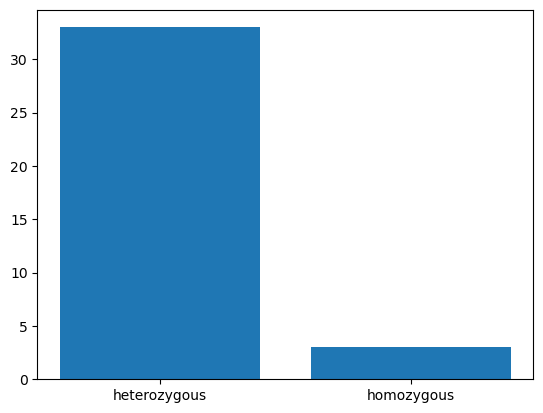

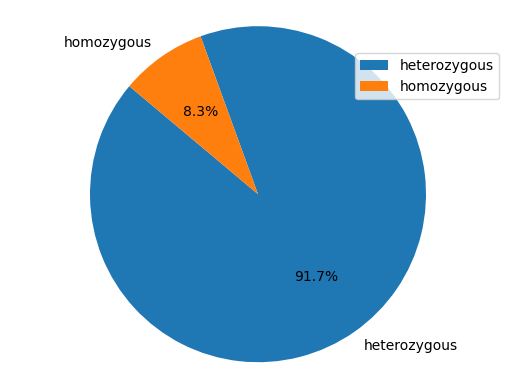

zygosity,count
str,u32
"""heterozygous""",33
"""homozygous""",3


In [158]:
grouped_by_zygosity = df.groupby('zygosity').count()
num_zygosity = grouped_by_zygosity.height

barchart(grouped_by_zygosity['zygosity'], grouped_by_zygosity['count'], figsize=figsize)
piechart(grouped_by_zygosity['zygosity'], grouped_by_zygosity['count'], figsize=figsize)

grouped_by_zygosity.head()

# 2. Sex Distribution

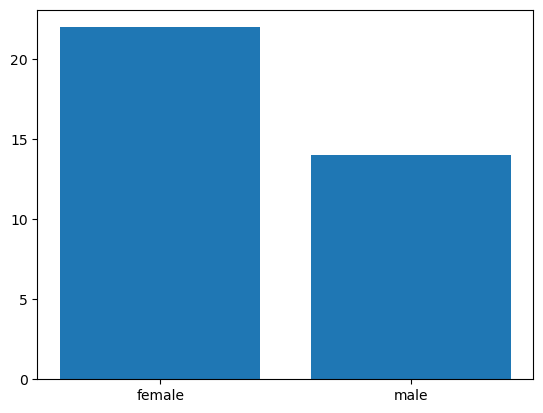

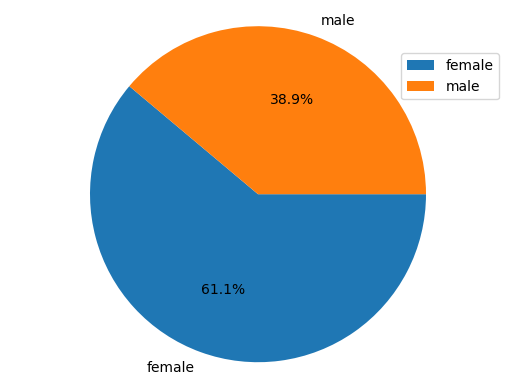

sex,count
str,u32
"""female""",22
"""male""",14


In [159]:
grouped_by_sex = df.groupby('sex').count()

barchart(grouped_by_sex['sex'], grouped_by_sex['count'], figsize=figsize)
piechart(grouped_by_sex['sex'], grouped_by_sex['count'], figsize=figsize)

grouped_by_sex.head()

# 3. c_hgvs variant distribution

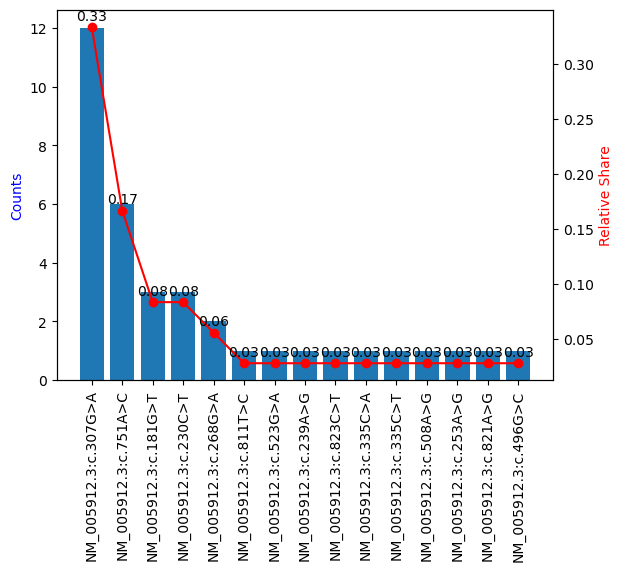

c_hgvs,count
str,u32
"""NM_005912.3:c.…",12
"""NM_005912.3:c.…",6
"""NM_005912.3:c.…",3
"""NM_005912.3:c.…",3
"""NM_005912.3:c.…",2
"""NM_005912.3:c.…",1
"""NM_005912.3:c.…",1
"""NM_005912.3:c.…",1
"""NM_005912.3:c.…",1


In [160]:
grouped_by_c_hgvs = df.groupby('c_hgvs').count().sort('count', descending=True)
num_c_hgvs = grouped_by_c_hgvs.height

# barchart(grouped_by_c_hgvs['c_hgvs'], grouped_by_c_hgvs['count'], figsize=figsize, x_tick_rotation='vertical')

barchart_relative_distribution(grouped_by_c_hgvs['c_hgvs'], grouped_by_c_hgvs['count'], figsize=figsize, x_tick_rotation='vertical')

grouped_by_c_hgvs.head(50)

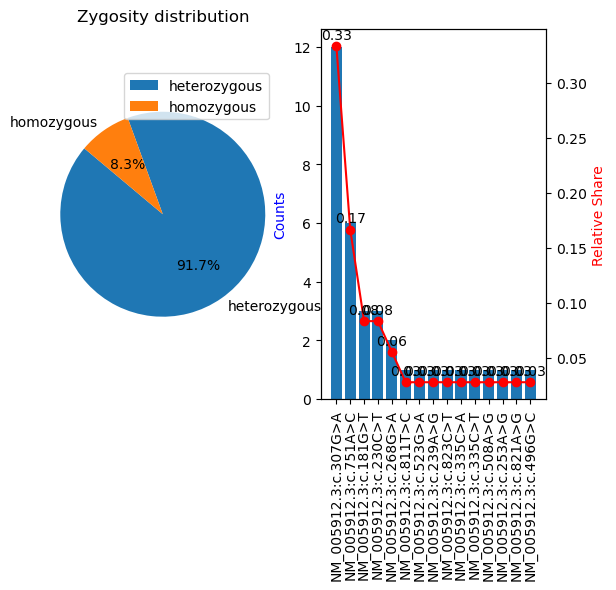

In [161]:
fig, (ax1, ax2) = plt.subplots(1, 2)
piechart_subplot(ax1, grouped_by_zygosity['zygosity'], grouped_by_zygosity['count'], 'Zygosity distribution',)
barchart_relative_distribution_subplot(ax2, grouped_by_c_hgvs['c_hgvs'], grouped_by_c_hgvs['count'], 'c_hgvs distribution', x_tick_rotation='vertical')
plt.show()

# 4. c_hgvs distribution by zygosity

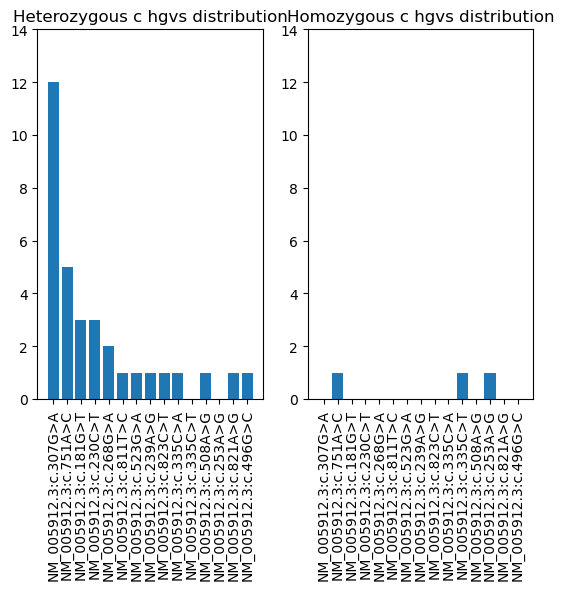

In [162]:
from ERKER2Phenopackets.src.utils.polars_utils import contingency_table

# barchart_3d(df, 'zygosity', 'c_hgvs', figsize=figsize, grouped_by_col1=grouped_by_zygosity, grouped_by_col2=grouped_by_c_hgvs) # not really useful

ct_zygosity_c_hgvs = contingency_table(df, 'zygosity', 'c_hgvs', grouped_by_zygosity['zygosity'], grouped_by_c_hgvs['c_hgvs'])
heterozygous_c_hgvs_frquency, homozygous_c_hgvs_frquency = ct_zygosity_c_hgvs[0], ct_zygosity_c_hgvs[1]
y_lim = int(np.max(ct_zygosity_c_hgvs) * 1.1) + 1

fig, (ax1, ax2) = plt.subplots(1, 2)
barchart_subplot(ax1, grouped_by_c_hgvs['c_hgvs'], heterozygous_c_hgvs_frquency, 'Heterozygous c hgvs distribution', x_tick_rotation='vertical', y_min=0, y_max=y_lim)
barchart_subplot(ax2, grouped_by_c_hgvs['c_hgvs'], homozygous_c_hgvs_frquency, 'Homozygous c hgvs distribution', x_tick_rotation='vertical', y_min=0, y_max=y_lim)
plt.show()

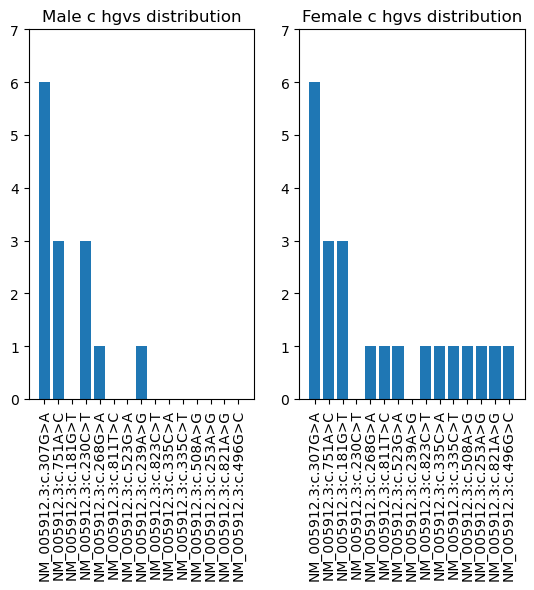

In [163]:
ct_sex_c_hgvs = contingency_table(df, 'sex', 'c_hgvs', ('male', 'female'), grouped_by_c_hgvs['c_hgvs'])
male_c_hgvs_frquency, female_c_hgvs_frquency = ct_sex_c_hgvs[0], ct_sex_c_hgvs[1]
y_lim = int(np.max(ct_sex_c_hgvs) * 1.1) + 1

fig, (ax1, ax2) = plt.subplots(1, 2)
barchart_subplot(ax1, grouped_by_c_hgvs['c_hgvs'], male_c_hgvs_frquency, 'Male c hgvs distribution', x_tick_rotation='vertical', y_min=0, y_max=y_lim)
barchart_subplot(ax2, grouped_by_c_hgvs['c_hgvs'], female_c_hgvs_frquency, 'Female c hgvs distribution', x_tick_rotation='vertical', y_min=0, y_max=y_lim)
plt.show()

# 4. Obesity Class Distribution

In [164]:
from ERKER2Phenopackets.src.utils.polars_utils import melt_groupby_count, sort_columns

# 4.1 count appearance of obesity classes/ hpo terms at each of the 3 inspections
obesity_class_count = melt_groupby_count(df, columns=[f'obesity_label{i}' for i in range(5)]).sort(by='value')

obesity_class_count = sort_columns(obesity_class_count, ['value'])

print(obesity_class_count.head(50))

shape: (6, 6)
┌────────────────┬────────────────┬────────────────┬───────────────┬───────────────┬───────────────┐
│ value          ┆ obesity_label0 ┆ obesity_label1 ┆ obesity_label ┆ obesity_label ┆ obesity_label │
│ ---            ┆ ---            ┆ ---            ┆ 2             ┆ 3             ┆ 4             │
│ str            ┆ u32            ┆ u32            ┆ ---           ┆ ---           ┆ ---           │
│                ┆                ┆                ┆ u32           ┆ u32           ┆ u32           │
╞════════════════╪════════════════╪════════════════╪═══════════════╪═══════════════╪═══════════════╡
│ Class I        ┆ 0              ┆ 4              ┆ 0             ┆ 1             ┆ 0             │
│ obesity        ┆                ┆                ┆               ┆               ┆               │
│ (HP:0025499)   ┆                ┆                ┆               ┆               ┆               │
│ Class II       ┆ 1              ┆ 1              ┆ 0             ┆ 0       

In [165]:
column_names = tuple(obesity_class_count['value'])
obesity_class_count_transpose = obesity_class_count.transpose(column_names=column_names)
if column_names != obesity_class_count_transpose.row(0):
    raise Exception('New column names do not match old row names')
obesity_class_count_transpose = obesity_class_count_transpose.tail(5).select(['Refuted Obesity (HP:0001513)', 'Overweight (HP:0025502)', 'Class I obesity (HP:0025499)', 'Class II obesity (HP:0025500)', 'Class III obesity (HP:0025501)'])
print(obesity_class_count_transpose.head(50))

shape: (5, 5)
┌─────────────────┬──────────────┬─────────────────┬──────────────────┬───────────────────┐
│ Refuted Obesity ┆ Overweight   ┆ Class I obesity ┆ Class II obesity ┆ Class III obesity │
│ (HP:0001513)    ┆ (HP:0025502) ┆ (HP:0025499)    ┆ (HP:0025500)     ┆ (HP:0025501)      │
│ ---             ┆ ---          ┆ ---             ┆ ---              ┆ ---               │
│ str             ┆ str          ┆ str             ┆ str              ┆ str               │
╞═════════════════╪══════════════╪═════════════════╪══════════════════╪═══════════════════╡
│ 28              ┆ 0            ┆ 0               ┆ 1                ┆ 0                 │
│ 6               ┆ 2            ┆ 4               ┆ 1                ┆ 0                 │
│ 3               ┆ 1            ┆ 0               ┆ 0                ┆ 0                 │
│ 1               ┆ 0            ┆ 1               ┆ 0                ┆ 0                 │
│ 0               ┆ 0            ┆ 0               ┆ 0            

In [166]:
def cast(column):
    return column.cast(pl.Int32).to_list()

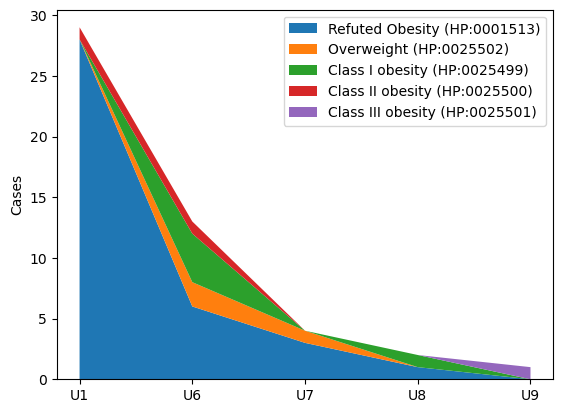

In [167]:
categories = obesity_class_count_transpose.columns

time_stamps = ['U1', 'U6', 'U7', 'U8', 'U9']


values = [cast(obesity_class_count_transpose[cat]) for cat in categories]

plt.figure(figsize=figsize)

plt.stackplot(range(5), values[0], values[1], values[2], values[3], values[4], labels=categories)
plt.xticks(range(5), time_stamps)
plt.ylabel('Cases')
plt.legend()
plt.show()

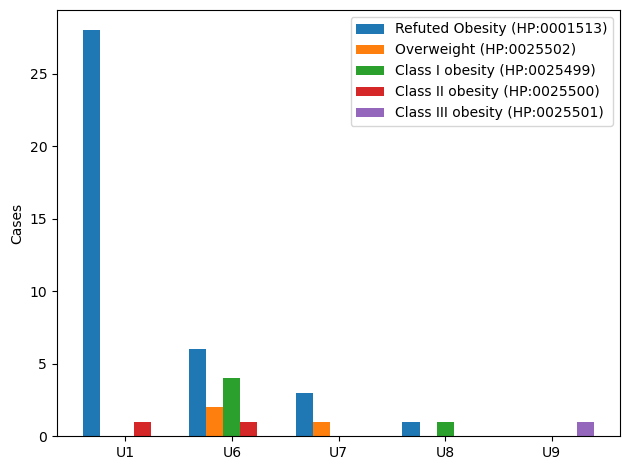

In [168]:
from ERKER2Phenopackets.src.utils.polars_utils import barchart_multiple

barchart_multiple(time_stamps, values, 'Cases', categories)

# Phenotype Transition Graphs
1. Markov chain style

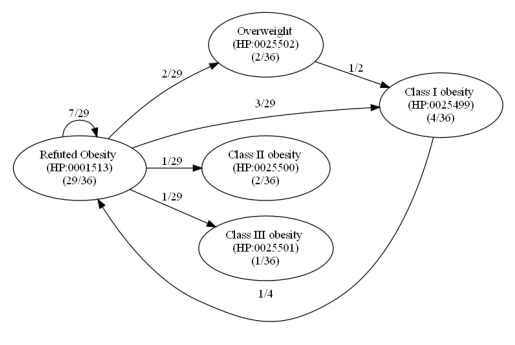

In [169]:
from ERKER2Phenopackets.src.analysis.ml.analysis_helper_methods import plot_phenotype_transition_graph

file_path = 'markov_chain_obesity_classes.png'
phenotype_labels = ['Refuted Obesity \n(HP:0001513)', 'Overweight \n(HP:0025502)', 'Class I obesity \n(HP:0025499)', 'Class II obesity \n(HP:0025500)', 'Class III obesity \n(HP:0025501)']

initial_counts_df = (melt_groupby_count(df, columns=
[f'obesity_label{i}' for i in range(5)])
                     .select(['value', 'obesity_label0'])
                     )
initial_counts_dict = {
    row['value']: row['obesity_label0']
    for row in initial_counts_df.to_struct('test')
}
initial_counts = (
        [initial_counts_dict[pheno_label]
         for pheno_label in categories]
        + [initial_counts_dict['Not recorded']]
)

plot_phenotype_transition_graph(df, 'obesity_label', phenotype_labels.copy(), initial_counts=initial_counts, count_not_recorded=True, percentages=False, file_path=file_path)

2. Patient Journey

In [170]:
from ERKER2Phenopackets.src.analysis.ml.analysis_helper_methods import index_similar
from ERKER2Phenopackets.src.utils.graphutils import graphplot
import networkx as nx

# def connect_rows(num_rows, num_nodes_per_row):
#     for row in range(1, num_rows):
#         for node_in_first_row in range(1, num_nodes_per_row + 1):
#             for node_in_next_row in range(1, num_nodes_per_row + 1):
#                 current_node_index = (row - 1) * num_nodes_per_row + node_in_first_row
#                 next_node_index = row * num_nodes_per_row + node_in_next_row
#                 yield current_node_index, next_node_index

file_path = 'time_split_graph_obesity_classes.png'
num_phenotype_labels = len(phenotype_labels)
num_phenotype_measurements = 5
source = 0
sink = len(categories)*5+1
not_recorded = -1

G = nx.DiGraph()
G.add_node(source, label='Source')
G.add_node(sink, label='Sink')
G.add_node(not_recorded, label='Not recorded')

node = 1
empty_nodes = []
# transition_counts = {i: [] for i in range(sink)}
for i in range(num_phenotype_measurements):
    target_addend = 1 + (i + 1) * num_phenotype_labels
    
    for label in phenotype_labels:
        row, col = i, (node - 1) % num_phenotype_labels
        count = int(obesity_class_count_transpose.item(row, col))
        if count == 0:
            empty_nodes.append(node)
        else:
            G.add_node(node, label=f'{label}\n{time_stamps[i]}\n{count}/{df.height}')
            
            if i < num_phenotype_measurements - 1:
                label_wo_newlines = categories[index_similar(categories, label)]
                # target nodes and how many patients transition to these targets
                outgoing = df.filter(df[f'obesity_label{i}'] == label_wo_newlines).select([f'obesity_label{i + 1}']).groupby(by=[f'obesity_label{i + 1}']).count()
                
                
                for target_label, count_transitioning_to_target in outgoing.rows():
                    target = not_recorded
                    try:
                        target = categories.index(target_label)
                    except ValueError:
                        pass
                    else: # if label in row
                        target += target_addend
                        
                    # add the edge
                    if G.has_edge(node, target):
                        G.edges[node, target]['denominator'] += count
                        G.edges[node, target]['numerator'] += count_transitioning_to_target
                    else:
                        G.add_edge(node, target, denominator=count, numerator=count_transitioning_to_target)   
                
        node += 1

# connect first row to source
for i in range(1, num_phenotype_labels + 1):
    if not i in empty_nodes:
        G.add_edge(source, i)

for edge in G.edges(data=True):
    from_, to, data = edge
    if data:
        G.edges[from_, to]['label'] = f'{data["numerator"]}/{data["denominator"]}'

# connect last row to sink 
for i in range(len(categories)*4+1, len(categories)*5+1):
    if not i in empty_nodes:
        G.add_edge(i, sink)
G.remove_node(not_recorded)

In [171]:
ccs = list(nx.connected_components(G.to_undirected()))
# determine largest connected component (this is the main graph) and remove it
max_component_id, max_component_length = max(
    ((i, len(component)) for i, component in enumerate(ccs)),
    key=lambda x: x[1],
    default=(-1, 0)
)
ccs = [component for i, component in enumerate(ccs) if i != max_component_id]

for cc in ccs: # assume each cc could have multiple nodes in multiple layers
    cc = list(cc)
    # separate the sinks and sources of the cc into layers 
    sources, sinks = [node for node in cc if G.in_degree(node) == 0], [node for node in cc if G.out_degree(node) == 0]
    layers = {i: [node for node in cc if i * num_phenotype_labels <= node < (i + 1) * num_phenotype_labels] for i in range(num_phenotype_measurements)}
    
    # 1. 
    while len(sources) > 0:
        for node in sources:
            previous = node - num_phenotype_labels
            if previous < source:
                previous = source
                
            if not G.has_node(previous):
                G.add_node(previous, label=f'{phenotype_labels[(previous - 1) % num_phenotype_labels]}\n{time_stamps[(previous - 1) // num_phenotype_labels]}\n?/?') # todo
                
            if not G.has_edge(previous, node):
                G.add_edge(previous, node, label="?") # todo
                
            if previous != source:
                cc.append(previous)
        
        sources = [node for node in cc if G.in_degree(node) == 0]
            
            
    # 2. find the last layer, go forwards until you hit source and add the connections
    while len(sinks) > 0:
        # 1. 
        for node in sinks:
            next_ = node + num_phenotype_labels
            if next_ > sink:
                next_ = sink
                
            if not G.has_node(next_):
                G.add_node(next_, label=f'{phenotype_labels[(next_ - 1) % num_phenotype_labels]}\n{time_stamps[(next_ - 1) // num_phenotype_labels]}\n?/?') # todo

            if not G.has_edge(node, next_):
                G.add_edge(node, next_, label="?") # todo
            
            if next_ != sink: 
                cc.append(next_)
        
        sinks = [node for node in cc if G.out_degree(node) == 0]
    
    # todo: add counts to the edges and nodes that were filled in

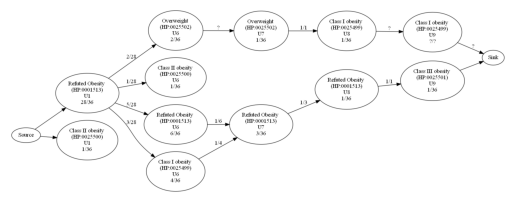

In [172]:
graphplot(G, file_path=file_path, orientation="LR")

In [173]:
# 5. What if we split the distribution of obesity classes by zygosity?

In [174]:
# 6. What if we split the distribution of obesity classes by c_hgvs mutation?

In [175]:
# 7. What if we split the distribution of obesity classes by c_hgvs mutation and zygosity?

In [176]:
# 8. How long does it take for a person to develop the different obesity classes based on their mutation?
# Welche Mutationen führt dazu vor dem 5ten lj obesity class 3 zu entwickeln und mit welcher Wahrscheinlichkeit?

In [177]:
# 9. Most severe mutation?